In [1]:
using Polynomials
using Plots
using Jacobi
using LinearAlgebra
using SparseArrays

In [15]:
function basis_function(N,d,x,k,range)
    basis_mat = zeros(N,N)*1.0
        for i=1:N
            for j=1:N
                Prod_temp=1
                for z=1:d
                    Prod_temp*=chebyshev(x[i,z],k[j,z])
                end
                basis_mat[i,j]=Prod_temp
            end
        end
        det_mat=det(basis_mat)
        boundary_func=vcat(map(x->range^2-x^2, x))
        func_value=det_mat*prod(boundary_func)
    return basis_mat,func_value,det_mat,prod(boundary_func)
end

basis_function (generic function with 1 method)

In [3]:
##切比雪夫多项式二阶导
function d2chebyshev(d2chebyshev_x,d2chebyshev_k)
    chebyshev_Tk=chebyshev(d2chebyshev_x, d2chebyshev_k)
    chebyshev_Uk=chebyshev2(d2chebyshev_x, d2chebyshev_k)
    if d2chebyshev_x!=1&-1
        d2_Tk=d2chebyshev_k*((d2chebyshev_k+1)*chebyshev_Tk-chebyshev_Uk)/(d2chebyshev_x^2-1)
    end
    if d2chebyshev_x==1
        d2_Tk=(d2chebyshev_k^4-d2chebyshev_k^2)/3
    end
    if d2chebyshev_x==-1
        d2_Tk=(-1)^k*(d2chebyshev_k^4-d2chebyshev_k^2)/3
    end
    return d2_Tk
end

d2chebyshev (generic function with 1 method)

In [65]:
function laplace_psi(N,d,x,k,range)
    Sum_laplace=0
    Prod_laplace=0
    Sum_laplace=0
    Prod_laplace=0
    basis_mat=basis_function(N,d,x,k,range)[1]
    basisfunc=basis_function(N,d,x,k,range)[2]
    det_mat=basis_function(N,d,x,k,range)[3]
    prod_boundary_func=basis_function(N,d,x,k,range)[4]
        for dimension=1:d
            for N_x=1:N
                    mat1=basis_function(N,d,x,k,range)[1]
                    mat2=basis_function(N,d,x,k,range)[1]
                    for i=1:N
                        #################d2T####################   
                        d2T_k=d2chebyshev(x[N_x,dimension], k[i,dimension])
                        T_k=Jacobi.chebyshev(x[N_x,dimension], k[i,dimension])
                        mat1[N_x,i]=basis_function(N,d,x,k,range)[1][N_x,i]*d2T_k/T_k
                        dT_ki=Jacobi.dchebyshev(x[N_x,dimension], k[i,dimension])
                        T_k_i=Jacobi.chebyshev(x[N_x,dimension], k[i,dimension])
                        mat2[N_x,i]=basis_function(N,d,x,k,range)[1][N_x,i]*dT_ki/T_k_i
                    end
                    Sum_laplace+=det(mat1)*prod_boundary_func
                    Sum_laplace+=2*det(mat2)*prod_boundary_func*(-2*x[N_x,dimension])/(range^2-x[N_x,dimension]^2)
                #################d2x####################
                Sum_laplace+=-2*basisfunc/(range^2-x[N_x,dimension]^2)
            end
        end
    return Sum_laplace
end

laplace_psi (generic function with 1 method)

In [66]:
        mat1=basis_function(N,d,x,k,range)[1]
                    for i=1:N
                        #################dTdT####################
                        dT_ki=Jacobi.dchebyshev(x[N_x,dimension], k[i,dimension])
                        T_k_i=Jacobi.chebyshev(x[N_x,dimension], k[i,dimension])
                        mat1[N_x,i]=basis_function(N,d,x,k,range)[1][N_x,i]*dT_ki/T_k_i
                        Sum_laplace+=2*det(mat1)*prod_boundary_func*(-2*x[N_x,dimension])/(range^2-x[N_x,dimension]^2)
                    end
                #################d2x####################
                Sum_laplace+=-2*basisfunc/(range^2-x[N_x,dimension]^2)

2.74107456e8

In [67]:
function V_psi(N,d,x,k,range)
    Sum_V=0
    Sum_r=0
    for i=1:N*d
        Sum_r+=x[i]^2
    end
        Sum_V=basis_function(N,d,x,k,range)[2]*Sum_r
    return Sum_V
end

V_psi (generic function with 1 method)

In [68]:
function H_psi(N,d,x,k,range)
       Sum_H_psi=-1/2*laplace_psi(N,d,x,k,range)+1/2*V_psi(N,d,x,k,range)
    return Sum_H_psi
end

H_psi (generic function with 1 method)

In [69]:
using Combinatorics
using BenchmarkTools
function nsumk(N,M)
    k=zeros(Int64,1,N)
    k_temp=collect(partitions(M+N,N))
    k_temp=vcat(map(e->collect(e)', k_temp)...)
    k_temp=k_temp-ones(Int64,size(k_temp))
    k=vcat(k,k_temp)
    return k
end

nsumk (generic function with 1 method)

In [70]:
function find_k(d,N,M)
    k_all=zeros(Int64,1,N*d)
    for i=1:M
        dividers=nsumk(N*d,i)
        k_all=vcat(k_all, dividers)
    end
    k_all=sort!(k_all,dims =2)
    k_all=unique(k_all,dims=1)
    k_all=k_all'
    number_of_k=size(k_all)[2]
    k_temp=zeros(Int64,1,N*d)
    i=0
    k_temp=collect(permutations(k_all[1+i*N*d:N*d+i*N*d]))
    k_temp=vcat(map(e->collect(e)', k_temp)...)
    k=k_temp
    for i=1:number_of_k-1
        k_temp=collect(permutations(k_all[1+i*N*d:N*d+i*N*d]))
        k_temp=vcat(map(e->collect(e)', k_temp)...)
        k=vcat(k, k_temp)
        k=unique(k,dims=1)
    end
    K=k'
    number_of_k=size(k)[1]
    K=reshape(K,number_of_k*N*d)
    K=reshape(K,N,d,number_of_k)
    K_unique=zeros(Int64,size(K))
    for i=1:number_of_k
        K[:,:,i]=sortslices(K[:,:,i],dims=1)
        if size(unique(K[:,:,i],dims=1))[1]>1
            K_unique[:,:,i]=K[:,:,i]
        end
    end
        K=unique(K_unique,dims=3)  
        Number_k=size(K)[3]
        K=K[:,:,2:Number_k]
   return K
end

find_k (generic function with 1 method)

In [71]:
function random_choose(Number_of_x,d,N,k,range)
    Number_of_k=size(k)[3]
    random_choose_X=rand(N,d,Number_of_x).*rand([-range,range],N,d,Number_of_x)
    random_choose_psi_x=zeros(Number_of_k,Number_of_x)
    random_choose_Hpsi_x=zeros(Number_of_k,Number_of_x)
    for i=1:Number_of_k
        for j=1:Number_of_x
            random_choose_psi_x[i,j]=basis_function(N,d,random_choose_X[:,:,j],k[:,:,i],range)[2]
            random_choose_Hpsi_x[i,j]=H_psi(N,d,random_choose_X[:,:,j],k[:,:,i],range)
        end
    end
    return random_choose_psi_x,random_choose_Hpsi_x,random_choose_X
end

random_choose (generic function with 1 method)

In [72]:
function least_squares(least_squares_x,least_squares_y)
    least_squares_C_k=inv(least_squares_x'*least_squares_x)*least_squares_x'*least_squares_y
    return least_squares_C_k
end

least_squares (generic function with 1 method)

In [73]:
function Eigenvalue(random_x,coef,alpha,d,N,k,range,Number_of_x;eps_x = 10^(-20),eps_d=0.001,maxIterations = 100)
    record=spzeros(maxIterations)
    basisfunction=random_x[1]
    H_basisfunction=random_x[2]
    for t in 1:maxIterations
            #若更换选点，取消以下注释
            #step_interval=10
            #if mod(t,step_interval)==0
                #random_x=random_choose(Number_of_x,d,N,k,range)
                #basisfunction=random_x[1]
                #H_basisfunction=random_x[2]
            #end
            reilaygh_quotient=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
            H_wave=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[2]
            coef=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[3]
            p=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[4]
            coef_H_wave=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[5]
            record[t]=reilaygh_quotient[1]
        if t>=3
            if abs(record[t]-record[t-1])+abs(record[t-1]-record[t-2])<=2*eps_d
                println("Convergence is reached after  ",t,"  iterations.")
                return coef,reilaygh_quotient,record
            end
        end
        alpha=steep(p,coef,reilaygh_quotient,coef_H_wave,basisfunction,N,d,range,H_basisfunction,Number_of_x,0,0.1,0.001,100)[1]
        println("============================步长为==========================",alpha)
        coef = coef-alpha*p
        println("At step ", t, " and reilaygh quotient = ", reilaygh_quotient)
    end
    println("Warning:",maxIterations,"  iterations have been exceeded")
    return coef,reilaygh_quotient,record
end

Eigenvalue (generic function with 1 method)

In [74]:
function reilaygh_quotient_alpha(coef_temp,basisfunction,H_basisfunction,N,d,range,Number_of_x)
        wave_temp=coef_temp*basisfunction
        sum_2_wave_temp=wave_temp*wave_temp'
        integal_wave_temp=(2*range)^(N*d)*sum_2_wave_temp/Number_of_x
        coef_temp=coef_temp/sqrt(integal_wave_temp[1])
        wave_temp=wave_temp/sqrt(integal_wave_temp[1])
        sum_2_wave_temp=sum_2_wave_temp/integal_wave_temp[1]
        H_wave_temp=coef_temp*H_basisfunction
        sum_wave_H_wave_temp=wave_temp*H_wave_temp'
        reilaygh_quotient_temp=sum_wave_H_wave_temp/sum_2_wave_temp
        coef_H_wave_temp=least_squares(basisfunction',H_wave_temp')
        coef_H_wave_temp=coef_H_wave_temp'
        p=coef_H_wave_temp-reilaygh_quotient_temp*coef_temp
    return reilaygh_quotient_temp,H_wave_temp,coef_temp,p,coef_H_wave_temp
end

reilaygh_quotient_alpha (generic function with 1 method)

In [75]:
function steep(p,coef,reilaygh_quotient,coef_H_wave,basisfunction,N,d,range,H_basisfunction,Number_of_x,a,b,eps_alpha,max)
        a_n=a
        b_n=b
        lambda=a+0.382*(b-a)
        mu=a+0.618*(b-a)
        phi_a=reilaygh_quotient_alpha(coef-a*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi_b=reilaygh_quotient_alpha(coef-b*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi_lambda=reilaygh_quotient_alpha(coef-lambda*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi_mu=reilaygh_quotient_alpha(coef-mu*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
        t=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[2]
        phi_max=findmax([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
    for i=1:max
        if t<3
            if b_n-a_n<eps_alpha
                return lambda
            end
            b_n=mu
            mu=lambda
            phi_b=phi_mu
            phi_mu=phi_lambda
            lambda=a_n+0.382*(b_n-a_n)
            phi_lambda=reilaygh_quotient_alpha(coef-lambda*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
            phi=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
            t=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[2]
            phi_max=findmax([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
        end
        if t>=3
           if b_n-a_n<eps_alpha
                return mu
           end
                a_n=lambda
                lambda=mu
                phi_a=phi_lambda
                phi_lambda=phi_mu
                mu=a_n+0.618*(b_n-a_n)
                phi_mu=reilaygh_quotient_alpha(coef-mu*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
                phi=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
                t=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[2]
                phi_max=findmax([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
        end
    end
    println("Warning:",max,"  iterations have been exceeded")
    return lambda
end

steep (generic function with 1 method)

In [77]:
d=1
N=2
M=20
@time k=find_k(d,N,M)
Number_of_x=40000
range=5
@time random_x=random_choose(Number_of_x,d,N,k,range)
Number_k=size(k)[3]
coef=ones(1,Number_k)
eps_x = 10^(-6)
eps_d=0.001
alpha=0.001
@time A=Eigenvalue(random_x,coef,alpha,d,N,k,range,Number_of_x;eps_x= 10^(-30),eps_d=10^(-7),maxIterations = 100000)

  0.223570 seconds (981.61 k allocations: 53.732 MiB, 5.33% gc time)
 44.927783 seconds (613.64 M allocations: 52.142 GiB, 8.59% gc time)
============================步长为==========================0.011147484577600002
At step 1 and reilaygh quotient = [23.444660094917268]
============================步长为==========================0.014280163222292164
At step 2 and reilaygh quotient = [20.733987820860513]
============================步长为==========================0.010836656716670556
At step 3 and reilaygh quotient = [19.017653565658875]
============================步长为==========================0.0159058780536279
At step 4 and reilaygh quotient = [17.919005988519597]
============================步长为==========================0.010334060891356802
At step 5 and reilaygh quotient = [17.00263949601877]
============================步长为==========================0.01784395309763448
At step 6 and reilaygh quotient = [16.297716660027262]
============================步长为==========================0.009831788

============================步长为==========================0.0360674538294711
At step 62 and reilaygh quotient = [3.860928084001573]
============================步长为==========================0.007200135130673806
At step 63 and reilaygh quotient = [3.802147377360368]
============================步长为==========================0.0403271635534432
At step 64 and reilaygh quotient = [3.746723864860279]
============================步长为==========================0.007200135130673806
At step 65 and reilaygh quotient = [3.689309805250242]
============================步长为==========================0.03525640963181476
At step 66 and reilaygh quotient = [3.635099796266908]
============================步长为==========================0.007392264869326196
At step 67 and reilaygh quotient = [3.5896006553115973]
============================步长为==========================0.03099891773199946
At step 68 and reilaygh quotient = [3.5466920275379183]
============================步长为==========================0.00739226486932

============================步长为==========================0.04132886705005742
At step 124 and reilaygh quotient = [2.8476323389999663]
============================步长为==========================0.007200135130673806
At step 125 and reilaygh quotient = [2.840902188917618]
============================步长为==========================0.037193214221920984
At step 126 and reilaygh quotient = [2.8339859175616584]
============================步长为==========================0.007200135130673806
At step 127 and reilaygh quotient = [2.827502134286318]
============================步长为==========================0.04132886705005742
At step 128 and reilaygh quotient = [2.820848542816628]
============================步长为==========================0.007200135130673806
At step 129 and reilaygh quotient = [2.813454108123303]
============================步长为==========================0.037193214221920984
At step 130 and reilaygh quotient = [2.8058473273908118]
============================步长为==========================0.00

============================步长为==========================0.015092939769753783
At step 186 and reilaygh quotient = [2.3687798767167845]
============================步长为==========================0.010142192914187949
At step 187 and reilaygh quotient = [2.3630963897625183]
============================步长为==========================0.014782459128623445
At step 188 and reilaygh quotient = [2.3573418385332916]
============================步长为==========================0.010334060891356802
At step 189 and reilaygh quotient = [2.3517838546511127]
============================步长为==========================0.014280163222292164
At step 190 and reilaygh quotient = [2.3461414827787768]
============================步长为==========================0.010644788739501703
At step 191 and reilaygh quotient = [2.340727912765144]
============================步长为==========================0.01346794847935324
At step 192 and reilaygh quotient = [2.3352216306322724]
============================步长为==========================

============================步长为==========================0.007200135130673806
At step 248 and reilaygh quotient = [2.0941160488358825]
============================步长为==========================0.03657089679922488
At step 249 and reilaygh quotient = [2.090618943986212]
============================步长为==========================0.007200135130673806
At step 250 and reilaygh quotient = [2.087108430168855]
============================步长为==========================0.03587820358362198
At step 251 and reilaygh quotient = [2.083810060828768]
============================步长为==========================0.007200135130673806
At step 252 and reilaygh quotient = [2.0805878216018736]
============================步长为==========================0.03657089679922488
At step 253 and reilaygh quotient = [2.0775715751643817]
============================步长为==========================0.007200135130673806
At step 254 and reilaygh quotient = [2.074526345255544]
============================步长为==========================0.035

============================步长为==========================0.006387296839686401
At step 310 and reilaygh quotient = [2.002499443615636]
============================步长为==========================0.0996892721518551
At step 311 and reilaygh quotient = [2.0024111248927596]
============================步长为==========================0.006387296839686401
At step 312 and reilaygh quotient = [2.0021536491159253]
============================步长为==========================0.0996892721518551
At step 313 and reilaygh quotient = [2.0020816978270677]
============================步长为==========================0.006076045416485857
At step 314 and reilaygh quotient = [2.0018701547263884]
============================步长为==========================0.0996892721518551
At step 315 and reilaygh quotient = [2.0018115687623435]
============================步长为==========================0.04821664190368531
At step 316 and reilaygh quotient = [2.0016007234641977]
============================步长为==========================0.0077

============================步长为==========================0.0996892721518551
At step 372 and reilaygh quotient = [2.00056004629883]
============================步长为==========================0.0172218357449847
At step 373 and reilaygh quotient = [2.0005497161705352]
============================步长为==========================0.0037557432833294456
At step 374 and reilaygh quotient = [2.0005463378636947]
============================步长为==========================0.0055742968000000006
At step 375 and reilaygh quotient = [2.00054579591612]
============================步长为==========================0.0996892721518551
At step 376 and reilaygh quotient = [2.0005456213116144]
============================步长为==========================0.019853812779343817
At step 377 and reilaygh quotient = [2.0005368594445114]
============================步长为==========================0.0034449154224
At step 378 and reilaygh quotient = [2.000533845653262]
============================步长为==========================0.0034449154

([0.0005226038345983719 7.618576288457456e-7 … -6.643386025648667e-22 5.583411415284814e-22], [2.000520228291051],   [1     ]  =  23.4447
  [2     ]  =  20.734
  [3     ]  =  19.0177
  [4     ]  =  17.919
  [5     ]  =  17.0026
  [6     ]  =  16.2977
  [7     ]  =  15.6302
  [8     ]  =  15.0846
  [9     ]  =  14.5671
  [10    ]  =  14.1369
            ⋮
  [379   ]  =  2.00053
  [380   ]  =  2.00053
  [381   ]  =  2.00053
  [382   ]  =  2.00053
  [383   ]  =  2.00053
  [384   ]  =  2.00053
  [385   ]  =  2.00053
  [386   ]  =  2.00052
  [387   ]  =  2.00052
  [388   ]  =  2.00052
  [389   ]  =  2.00052)

In [78]:
##########################
#求 d=1 N=3 M=2:20 reilaygh quotient变化
#运行时间较长
##########################
d=1
N=2
M=2
k=find_k(d,N,M)
range=5
Number_k=size(k)[3]
c_k=ones(1,Number_k)
eps_x = 10^(-6)
eps_d=0.001
alpha=0.001
Number_of_x=40000
record_time=zeros(1,20)
println("=================================M=",M,"==============================================")
#println("========================选点并计算基函数值时间如下","==============================================")
#@time random_x=random_choose(Number_of_x,d,N,k,range)
time = @elapsed random_x=random_choose(Number_of_x,d,N,k,range)
record_time[1]=time
time = @elapsed df1=Eigenvalue(random_x,c_k,alpha,d,N,k,range,Number_of_x;eps_x= 10^(-30),eps_d=10^(-7),maxIterations = 100000)[3]    
record_time[2]=time
#println("========================梯度下降时间如上","==============================================")
t=1
for M in 4:2:20
    println("=================================M=",M,"==============================================")
    k=find_k(d,N,M)
    Number_k=size(k)[3]
    c_k=ones(1,Number_k)
    #println("========================选点并计算基函数值时间如下","==============================================")
    time = @elapsed random_x=random_choose(Number_of_x,d,N,k,range)
    record_time[2*t+1]=time
    time = @elapsed df2=Eigenvalue(random_x,c_k,alpha,d,N,k,range,Number_of_x;eps_x= 10^(-30),eps_d=10^(-7),maxIterations = 100000)[3]  
    record_time[2*t+2]=time
    #println("========================梯度下降时间如上","==============================================")
    record=hcat(df1, df2)
    df1=record
    t=t+1
end

=================================M=2==============================================
============================步长为==========================0.0996892721518551
At step 1 and reilaygh quotient = [7.318451094985431]
============================步长为==========================0.0996892721518551
At step 2 and reilaygh quotient = [7.303681537353945]
============================步长为==========================0.0996892721518551
At step 3 and reilaygh quotient = [7.2857617793929315]
============================步长为==========================0.0996892721518551
At step 4 and reilaygh quotient = [7.264154942821494]
============================步长为==========================0.0996892721518551
At step 5 and reilaygh quotient = [7.238298288096157]
============================步长为==========================0.0996892721518551
At step 6 and reilaygh quotient = [7.207635658744008]
============================步长为==========================0.0996892721518551
At step 7 and reilaygh quotient = [7.171665742566039]
======

============================步长为==========================0.0996892721518551
At step 69 and reilaygh quotient = [6.212332119670828]
============================步长为==========================0.0996892721518551
At step 70 and reilaygh quotient = [6.212331692690291]
============================步长为==========================0.0996892721518551
At step 71 and reilaygh quotient = [6.212331347230641]
============================步长为==========================0.0996892721518551
At step 72 and reilaygh quotient = [6.212331066816098]
============================步长为==========================0.0996892721518551
At step 73 and reilaygh quotient = [6.212330838423013]
============================步长为==========================0.0996892721518551
At step 74 and reilaygh quotient = [6.212330651741071]
============================步长为==========================0.0996892721518551
At step 75 and reilaygh quotient = [6.212330498594456]
============================步长为==========================0.0996892721518551
At step

============================步长为==========================0.0996892721518551
At step 54 and reilaygh quotient = [3.931628428206511]
============================步长为==========================0.0996892721518551
At step 55 and reilaygh quotient = [3.931573641544063]
============================步长为==========================0.0996892721518551
At step 56 and reilaygh quotient = [3.9315317150456646]
============================步长为==========================0.0996892721518551
At step 57 and reilaygh quotient = [3.931499674822553]
============================步长为==========================0.0996892721518551
At step 58 and reilaygh quotient = [3.931475229222185]
============================步长为==========================0.0996892721518551
At step 59 and reilaygh quotient = [3.931456613053651]
============================步长为==========================0.0996892721518551
At step 60 and reilaygh quotient = [3.9314424672582335]
============================步长为==========================0.0996892721518551
At st

============================步长为==========================0.0996892721518551
At step 42 and reilaygh quotient = [2.933662988947828]
============================步长为==========================0.0996892721518551
At step 43 and reilaygh quotient = [2.9285656339832866]
============================步长为==========================0.0996892721518551
At step 44 and reilaygh quotient = [2.9245113749090104]
============================步长为==========================0.0996892721518551
At step 45 and reilaygh quotient = [2.921292714166612]
============================步长为==========================0.0996892721518551
At step 46 and reilaygh quotient = [2.9187411027008388]
============================步长为==========================0.0996892721518551
At step 47 and reilaygh quotient = [2.9167205313403683]
============================步长为==========================0.0996892721518551
At step 48 and reilaygh quotient = [2.915121814598074]
============================步长为==========================0.0996892721518551
At 

============================步长为==========================0.0996892721518551
At step 11 and reilaygh quotient = [4.005324429588459]
============================步长为==========================0.0996892721518551
At step 12 and reilaygh quotient = [3.7227893484524146]
============================步长为==========================0.0996892721518551
At step 13 and reilaygh quotient = [3.5751728677260575]
============================步长为==========================0.0996892721518551
At step 14 and reilaygh quotient = [3.503494967201037]
============================步长为==========================0.0996892721518551
At step 15 and reilaygh quotient = [3.4679284381504005]
============================步长为==========================0.0996892721518551
At step 16 and reilaygh quotient = [3.4478163115675398]
============================步长为==========================0.0996892721518551
At step 17 and reilaygh quotient = [3.4335414155351884]
============================步长为==========================0.0996892721518551
At

============================步长为==========================0.0996892721518551
At step 74 and reilaygh quotient = [2.4236283246114714]
============================步长为==========================0.0996892721518551
At step 75 and reilaygh quotient = [2.423607567233578]
============================步长为==========================0.0996892721518551
At step 76 and reilaygh quotient = [2.4235908605948797]
============================步长为==========================0.0996892721518551
At step 77 and reilaygh quotient = [2.4235774071796015]
============================步长为==========================0.0996892721518551
At step 78 and reilaygh quotient = [2.4235665672156856]
============================步长为==========================0.0996892721518551
At step 79 and reilaygh quotient = [2.4235578274038927]
============================步长为==========================0.0996892721518551
At step 80 and reilaygh quotient = [2.4235507758540935]
============================步长为==========================0.0996892721518551
A

============================步长为==========================0.0763924
At step 34 and reilaygh quotient = [2.9897095337951765]
============================步长为==========================0.07820942093199945
At step 35 and reilaygh quotient = [2.9641003418757053]
============================步长为==========================0.07557776736285794
At step 36 and reilaygh quotient = [2.9361104906101145]
============================步长为==========================0.07820942093199945
At step 37 and reilaygh quotient = [2.906230499697347]
============================步长为==========================0.07426233324655679
At step 38 and reilaygh quotient = [2.874155287494078]
============================步长为==========================0.0785206723552
At step 39 and reilaygh quotient = [2.840497385388519]
============================步长为==========================0.07313915254909759
At step 40 and reilaygh quotient = [2.805095828262026]
============================步长为==========================0.07820942093199945
At step 41

============================步长为==========================0.056228606400000006
At step 97 and reilaygh quotient = [2.1835019062480208]
============================步长为==========================0.0996892721518551
At step 98 and reilaygh quotient = [2.1834537979535793]
============================步长为==========================0.053791200296614224
At step 99 and reilaygh quotient = [2.183405914596012]
============================步长为==========================0.0996892721518551
At step 100 and reilaygh quotient = [2.1833692909419655]
============================步长为==========================0.0567313022380983
At step 101 and reilaygh quotient = [2.183332108394929]
============================步长为==========================0.0996892721518551
At step 102 and reilaygh quotient = [2.183306208040453]
============================步长为==========================0.053601388037929604
At step 103 and reilaygh quotient = [2.183278949965173]
============================步长为==========================0.09968927215

============================步长为==========================0.04214128186304266
At step 9 and reilaygh quotient = [7.740528978837471]
============================步长为==========================0.09392395458351414
At step 10 and reilaygh quotient = [7.266535668441986]
============================步长为==========================0.04063672072754258
At step 11 and reilaygh quotient = [6.796204739946517]
============================步长为==========================0.0904792009619017
At step 12 and reilaygh quotient = [6.360871731833432]
============================步长为==========================0.03951031353338687
At step 13 and reilaygh quotient = [5.949001142920128]
============================步长为==========================0.08784807096781586
At step 14 and reilaygh quotient = [5.580475270212377]
============================步长为==========================0.03901172943714205
At step 15 and reilaygh quotient = [5.242723690580841]
============================步长为==========================0.08509751935501174
A

============================步长为==========================0.06342910320077512
At step 72 and reilaygh quotient = [2.2936735066419716]
============================步长为==========================0.04082669478701476
At step 73 and reilaygh quotient = [2.275845314828936]
============================步长为==========================0.0639325461705289
At step 74 and reilaygh quotient = [2.259060713920158]
============================步长为==========================0.04063672072754258
At step 75 and reilaygh quotient = [2.243323814776983]
============================步长为==========================0.06361913884753848
At step 76 and reilaygh quotient = [2.228632202091007]
============================步长为==========================0.04063672072754258
At step 77 and reilaygh quotient = [2.214996509250632]
============================步长为==========================0.06342910320077512
At step 78 and reilaygh quotient = [2.202354376010171]
============================步长为==========================0.04063672072754258

============================步长为==========================0.04264403945695324
At step 134 and reilaygh quotient = [2.070762347971885]
============================步长为==========================0.05917330521298524
At step 135 and reilaygh quotient = [2.0707152394852972]
============================步长为==========================0.04113957836642844
At step 136 and reilaygh quotient = [2.070670667526632]
============================步长为==========================0.06261737376363308
At step 137 and reilaygh quotient = [2.070631678273955]
============================步长为==========================0.03951031353338687
At step 138 and reilaygh quotient = [2.070594517685485]
============================步长为==========================0.06706310713261174
At step 139 and reilaygh quotient = [2.070562126442601]
============================步长为==========================0.03788492214269821
At step 140 and reilaygh quotient = [2.0705309689192104]
============================步长为==========================0.07263665

============================步长为==========================0.05522637932833014
At step 2 and reilaygh quotient = [15.526016896845768]
============================步长为==========================0.0318113325449847
At step 3 and reilaygh quotient = [13.801032685721447]
============================步长为==========================0.05441311774775951
At step 4 and reilaygh quotient = [12.742593693834662]
============================步长为==========================0.0318113325449847
At step 5 and reilaygh quotient = [11.928422022914306]
============================步长为==========================0.05297770020821742
At step 6 and reilaygh quotient = [11.271997811966408]
============================步长为==========================0.03150099008642434
At step 7 and reilaygh quotient = [10.699679323149926]
============================步长为==========================0.05097094328332945
At step 8 and reilaygh quotient = [10.197121108406101]
============================步长为==========================0.03162083518314475
A

============================步长为==========================0.03638086115246152
At step 65 and reilaygh quotient = [2.9623817566760366]
============================步长为==========================0.0331270284227694
At step 66 and reilaygh quotient = [2.955914629082756]
============================步长为==========================0.037193214221920984
At step 67 and reilaygh quotient = [2.9494399862037444]
============================步长为==========================0.03293689286738826
At step 68 and reilaygh quotient = [2.9427363848584385]
============================步长为==========================0.03738262623636693
At step 69 and reilaygh quotient = [2.9359418591011974]
============================步长为==========================0.03293689286738826
At step 70 and reilaygh quotient = [2.9288434620478263]
============================步长为==========================0.03769655703024623
At step 71 and reilaygh quotient = [2.921583565346669]
============================步长为==========================0.032623909022

============================步长为==========================0.03707423960755012
At step 127 and reilaygh quotient = [2.150111930858772]
============================步长为==========================0.0313108545310432
At step 128 and reilaygh quotient = [2.1422210319179986]
============================步长为==========================0.03638086115246152
At step 129 and reilaygh quotient = [2.1346495562996974]
============================步长为==========================0.0318113325449847
At step 130 and reilaygh quotient = [2.127588288152237]
============================步长为==========================0.03556749939058524
At step 131 and reilaygh quotient = [2.1208150188327917]
============================步长为==========================0.032434497007954054
At step 132 and reilaygh quotient = [2.1145183366445766]
============================步长为==========================0.03494570543877802
At step 133 and reilaygh quotient = [2.1084800731989044]
============================步长为==========================0.032936

============================步长为==========================0.0188485212844864
At step 189 and reilaygh quotient = [2.0193849860287534]
============================步长为==========================0.0996892721518551
At step 190 and reilaygh quotient = [2.019362836685777]
============================步长为==========================0.0227950235225847
At step 191 and reilaygh quotient = [2.0193252961111154]
============================步长为==========================0.0931108545310432
At step 192 and reilaygh quotient = [2.0193170931986795]
============================步长为==========================0.0172218357449847
At step 193 and reilaygh quotient = [2.019299123962652]
============================步长为==========================0.0996892721518551
At step 194 and reilaygh quotient = [2.019288964627858]
============================步长为==========================0.0996892721518551
At step 195 and reilaygh quotient = [2.0192732905413626]
============================步长为==========================0.0509709432833

============================步长为==========================0.016217391290400545
At step 49 and reilaygh quotient = [3.5446816668386614]
============================步长为==========================0.04276610193658795
At step 50 and reilaygh quotient = [3.4885332968879]
============================步长为==========================0.016217391290400545
At step 51 and reilaygh quotient = [3.436421612086952]
============================步长为==========================0.041638424224156804
At step 52 and reilaygh quotient = [3.389022274154092]
============================步长为==========================0.016217391290400545
At step 53 and reilaygh quotient = [3.3463262570186183]
============================步长为==========================0.04214128186304266
At step 54 and reilaygh quotient = [3.307534038259989]
============================步长为==========================0.016217391290400545
At step 55 and reilaygh quotient = [3.2718195410443]
============================步长为==========================0.04132886705005

============================步长为==========================0.014089542361114146
At step 111 and reilaygh quotient = [2.4579506884961204]
============================步长为==========================0.07112929286738826
At step 112 and reilaygh quotient = [2.4367851230940536]
============================步长为==========================0.014089542361114146
At step 113 and reilaygh quotient = [2.4157686891081185]
============================步长为==========================0.07062689700795405
At step 114 and reilaygh quotient = [2.395276824457731]
============================步长为==========================0.014089542361114146
At step 115 and reilaygh quotient = [2.375065409066313]
============================步长为==========================0.06981365874541584
At step 116 and reilaygh quotient = [2.3554442576315977]
============================步长为==========================0.014089542361114146
At step 117 and reilaygh quotient = [2.3363135069369845]
============================步长为==========================0.0

============================步长为==========================0.012965190885442658
At step 173 and reilaygh quotient = [2.0084283227606656]
============================步长为==========================0.0996892721518551
At step 174 and reilaygh quotient = [2.008140258415057]
============================步长为==========================0.013276442308643202
At step 175 and reilaygh quotient = [2.0078196007314193]
============================步长为==========================0.0996892721518551
At step 176 and reilaygh quotient = [2.007629752161787]
============================步长为==========================0.012773846483329448
At step 177 and reilaygh quotient = [2.007405249360364]
============================步长为==========================0.0996892721518551
At step 178 and reilaygh quotient = [2.007228117806233]
============================步长为==========================0.01377776736285796
At step 179 and reilaygh quotient = [2.0070038715663006]
============================步长为==========================0.0862222

============================步长为==========================0.014782459128623445
At step 5 and reilaygh quotient = [15.270361706367739]
============================步长为==========================0.0236076
At step 6 and reilaygh quotient = [14.59439826135778]
============================步长为==========================0.014280163222292164
At step 7 and reilaygh quotient = [13.987049975168688]
============================步长为==========================0.024732051520646763
At step 8 and reilaygh quotient = [13.479815902323987]
============================步长为==========================0.01377776736285796
At step 9 and reilaygh quotient = [13.007468005041497]
============================步长为==========================0.026550243230858504
At step 10 and reilaygh quotient = [12.601699718951341]
============================步长为==========================0.013276442308643202
At step 11 and reilaygh quotient = [12.21165562306528]
============================步长为==========================0.028057807085812052
At 

============================步长为==========================0.010334060891356802
At step 67 and reilaygh quotient = [3.5824736063934965]
============================步长为==========================0.047210503200000004
At step 68 and reilaygh quotient = [3.531470409775849]
============================步长为==========================0.010023394863412053
At step 69 and reilaygh quotient = [3.475497475440215]
============================步长为==========================0.05097094328332945
At step 70 and reilaygh quotient = [3.4256362043544635]
============================步长为==========================0.009831788699815304
At step 71 and reilaygh quotient = [3.376003605117429]
============================步长为==========================0.05654132834714722
At step 72 and reilaygh quotient = [3.3320389532221917]
============================步长为==========================0.009520799038098299
At step 73 and reilaygh quotient = [3.287806799283292]
============================步长为==========================0.073760746

============================步长为==========================0.009329292867388261
At step 129 and reilaygh quotient = [2.2216220509924924]
============================步长为==========================0.07476519088544265
At step 130 and reilaygh quotient = [2.2074048746050834]
============================步长为==========================0.009329292867388261
At step 131 and reilaygh quotient = [2.19369943549438]
============================步长为==========================0.07457384648332945
At step 132 and reilaygh quotient = [2.180956706036398]
============================步长为==========================0.009329292867388261
At step 133 and reilaygh quotient = [2.168684104389704]
============================步长为==========================0.0737607464308585
At step 134 and reilaygh quotient = [2.1572908977807224]
============================步长为==========================0.009329292867388261
At step 135 and reilaygh quotient = [2.1464480988823427]
============================步长为==========================0.0739

============================步长为==========================0.009520799038098299
At step 191 and reilaygh quotient = [2.0058399806056193]
============================步长为==========================0.07062689700795405
At step 192 and reilaygh quotient = [2.0057199329385056]
============================步长为==========================0.009329292867388261
At step 193 and reilaygh quotient = [2.0055764053759364]
============================步长为==========================0.07112929286738826
At step 194 and reilaygh quotient = [2.005448103889498]
============================步长为==========================0.009329292867388261
At step 195 and reilaygh quotient = [2.0053262539633376]
============================步长为==========================0.0708181032
At step 196 and reilaygh quotient = [2.0052174918503125]
============================步长为==========================0.009329292867388261
At step 197 and reilaygh quotient = [2.00511354501801]
============================步长为==========================0.066560611

============================步长为==========================0.0124623332465568
At step 253 and reilaygh quotient = [2.004004739633406]
============================步长为==========================0.02887070713261174
At step 254 and reilaygh quotient = [2.004004376690374]
============================步长为==========================0.010836656716670556
At step 255 and reilaygh quotient = [2.0040038726048106]
============================步长为==========================0.04113957836642844
At step 256 and reilaygh quotient = [2.004003461123366]
============================步长为==========================0.009520799038098299
At step 257 and reilaygh quotient = [2.0040028891090866]
============================步长为==========================0.08703480911455735
At step 258 and reilaygh quotient = [2.004002420626132]
============================步长为==========================0.008707698985627356
At step 259 and reilaygh quotient = [2.0040015145778796]
============================步长为==========================0.09968

============================步长为==========================0.025928649349097596
At step 45 and reilaygh quotient = [6.647024697129683]
============================步长为==========================0.008013658745415845
At step 46 and reilaygh quotient = [6.532135330039748]
============================步长为==========================0.025737666753443203
At step 47 and reilaygh quotient = [6.418723308593327]
============================步长为==========================0.008013658745415845
At step 48 and reilaygh quotient = [6.308005087357019]
============================步长为==========================0.025737666753443203
At step 49 and reilaygh quotient = [6.198613379452881]
============================步长为==========================0.008013658745415845
At step 50 and reilaygh quotient = [6.09187710777132]
============================步长为==========================0.025234809114557347
At step 51 and reilaygh quotient = [5.985610002387325]
============================步长为==========================0.00801365874

============================步长为==========================0.0278659391086432
At step 107 and reilaygh quotient = [3.1503780913779122]
============================步长为==========================0.007392264869326196
At step 108 and reilaygh quotient = [3.1375467781815507]
============================步长为==========================0.0334393886998153
At step 109 and reilaygh quotient = [3.125645989918218]
============================步长为==========================0.007200135130673806
At step 110 and reilaygh quotient = [3.11255740900711]
============================步长为==========================0.035065488791972646
At step 111 and reilaygh quotient = [3.1004859746202116]
============================步长为==========================0.007200135130673806
At step 112 and reilaygh quotient = [3.088569048714079]
============================步长为==========================0.03363004772608531
At step 113 and reilaygh quotient = [3.07762989636625]
============================步长为==========================0.0072001

============================步长为==========================0.03525640963181476
At step 169 and reilaygh quotient = [2.728962889851155]
============================步长为==========================0.007200135130673806
At step 170 and reilaygh quotient = [2.720373658099905]
============================步长为==========================0.03738262623636693
At step 171 and reilaygh quotient = [2.7117655725309495]
============================步长为==========================0.007200135130673806
At step 172 and reilaygh quotient = [2.702468591234256]
============================步长为==========================0.035065488791972646
At step 173 and reilaygh quotient = [2.6930989808554595]
============================步长为==========================0.007200135130673806
At step 174 and reilaygh quotient = [2.6839703826279595]
============================步长为==========================0.037193214221920984
At step 175 and reilaygh quotient = [2.6747678796917547]
============================步长为==========================0.0

============================步长为==========================0.03494570543877802
At step 231 and reilaygh quotient = [2.1609179614059593]
============================步长为==========================0.007200135130673806
At step 232 and reilaygh quotient = [2.1553108290750442]
============================步长为==========================0.0334393886998153
At step 233 and reilaygh quotient = [2.1497456511243405]
============================步长为==========================0.007392264869326196
At step 234 and reilaygh quotient = [2.1446494354647836]
============================步长为==========================0.027555211260498296
At step 235 and reilaygh quotient = [2.139573956986537]
============================步长为==========================0.0077032545310432
At step 236 and reilaygh quotient = [2.1354197907333936]
============================步长为==========================0.02461321523279644
At step 237 and reilaygh quotient = [2.131273110043801]
============================步长为==========================0.0078

============================步长为==========================0.0068891454689568
At step 293 and reilaygh quotient = [2.0135755504936497]
============================步长为==========================0.0567313022380983
At step 294 and reilaygh quotient = [2.013094834728795]
============================步长为==========================0.006387296839686401
At step 295 and reilaygh quotient = [2.0122815488071897]
============================步长为==========================0.0996892721518551
At step 296 and reilaygh quotient = [2.0115761823850504]
============================步长为==========================0.006076045416485857
At step 297 and reilaygh quotient = [2.0102018543154916]
============================步长为==========================0.0996892721518551
At step 298 and reilaygh quotient = [2.0093918304075173]
============================步长为==========================0.009329292867388261
At step 299 and reilaygh quotient = [2.0077755160720145]
============================步长为==========================0.01966

============================步长为==========================0.007894598933156412
At step 355 and reilaygh quotient = [2.000866456178346]
============================步长为==========================0.0996892721518551
At step 356 and reilaygh quotient = [2.000865555353415]
============================步长为==========================0.0045690051365879485
At step 357 and reilaygh quotient = [2.000841663416539]
============================步长为==========================0.004450207085812052
At step 358 and reilaygh quotient = [2.0008340649120693]
============================步长为==========================0.06079902004432097
At step 359 and reilaygh quotient = [2.00083367105163]
============================步长为==========================0.010142192914187949
At step 360 and reilaygh quotient = [2.000828283140324]
============================步长为==========================0.003253247450902403
At step 361 and reilaygh quotient = [2.0008170131255416]
============================步长为==========================0.0047

In [79]:
logocolors = Colors.JULIA_LOGO_COLORS
color_choose=(logocolors.blue, logocolors.red, logocolors.green, logocolors.purple)

(RGB{N0f8}(0.251,0.388,0.847), RGB{N0f8}(0.796,0.235,0.2), RGB{N0f8}(0.22,0.596,0.149), RGB{N0f8}(0.584,0.345,0.698))

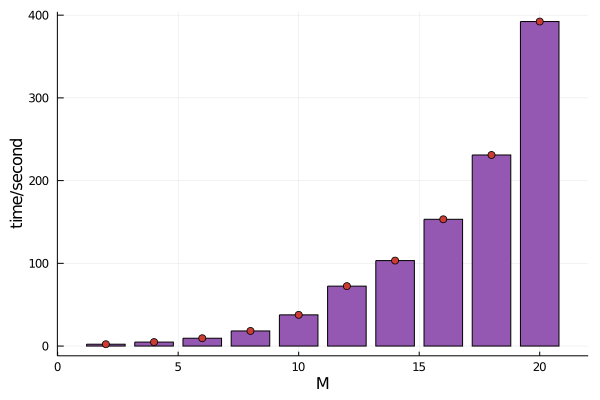

In [80]:
#画时间图
x=collect(2:2:20)
time=sum(reshape(record_time,2,:),dims=1)'
Plots.bar(x,time,linewidth=1,xlabel="M",ylabel="time/second",label="",color=color_choose[4],align="center")
scatter!(x,time,label="",color=color_choose[2])

In [81]:
true_value=N^2/2
record=df1
reilaygh_quotient_array=zeros(2000,1,10)
reilaygh_quotient_array_ln=zeros(2000,1,10)
for i=1:10
    reilaygh_quotient_array1=findall(!iszero, record[:,i])
    step=size(reilaygh_quotient_array1)
    temp=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
    for j=1:step[1]
        reilaygh_quotient_array[j,1,i]=temp[j]
    end
    reilaygh_quotient_array_ln[1:step[1],1,i]=map((x) -> log(abs(x)), reilaygh_quotient_array[1:step[1],1,i])
end

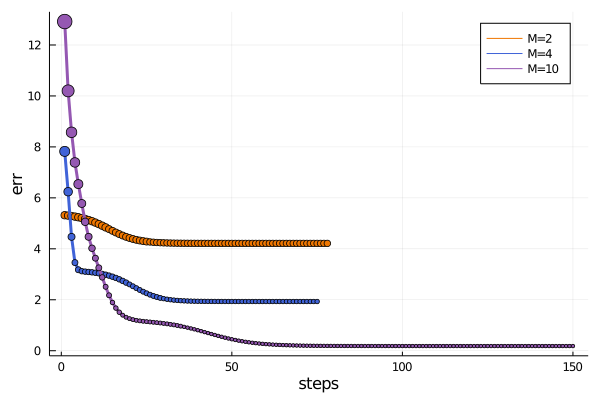

In [93]:
i=1
step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
plot(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color="darkorange2")
scatter!(temp,ms = 0.5*abs.(temp .- 0.5) .+ 2, lab = "",color="darkorange2")
for i=2:2
    step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
    temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
    plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[i-1])
    scatter!(temp,ms = 0.5*abs.(temp .- 0.5) .+ 2, lab = "",color=color_choose[i-1])
end
i=5
step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[i-1])
scatter!(temp,ms = 0.5*abs.(temp .- 0.5) .+ 2, lab = "",color=color_choose[i-1])

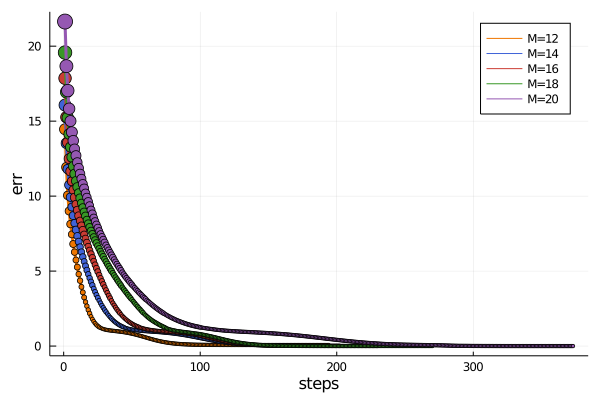

In [83]:
i=6
step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
plot(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color="darkorange2")
scatter!(temp,ms = 0.3*abs.(temp .- 0.5) .+ 2, lab = "",color="darkorange2")
for i=7:9
    step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
    temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
    plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[i-6])
    scatter!(temp,ms = 0.3*abs.(temp .- 0.5) .+ 2, lab = "",color=color_choose[i-6])
end
i=10
step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[i-6])
scatter!(temp,ms = 0.3*abs.(temp .- 0.5) .+ 2, lab = "",color=color_choose[i-6])

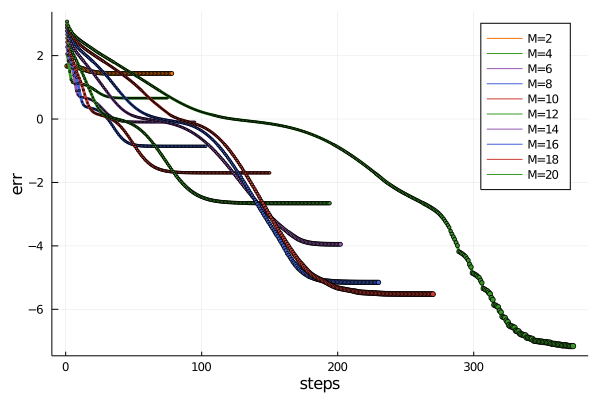

In [84]:
i=1
step=size(findall(!iszero, reilaygh_quotient_array_ln[:,1,i]))[1]
temp=Array(reilaygh_quotient_array_ln[:,1,i][1:step[1]])
plot(temp,w = 3,xlabel="steps",ylabel="ln_err",label=string("M=", 2*i),color="darkorange2")
scatter!(temp,ms = 0.5*abs.(temp .- 0.5) .+ 2, lab = "",color="darkorange2")
for i=2:9
    step=size(findall(!iszero, reilaygh_quotient_array_ln[:,1,i]))[1]
    temp=Array(reilaygh_quotient_array_ln[:,1,i][1:step[1]])
    plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[mod(i,4)+1])
    scatter!(temp,ms = 0.3*abs.(temp .- 0.5) .+ 1, lab = "",color=color_choose[mod(i,4)+1])
end
i=10
step=size(findall(!iszero, reilaygh_quotient_array_ln[:,1,i]))[1]
temp=Array(reilaygh_quotient_array_ln[:,1,i][1:step[1]])
plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[mod(i,4)+1])
scatter!(temp,ms = 0.3*abs.(temp .- 0.5) .+ 1, lab = "",color=color_choose[mod(i,4)+1])

In [85]:
err=zeros(1,10)
for i=1:10
    step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
    temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
    err[i]=temp[step[1]][1]
end
err=err'
ln_err=map(x->log(abs(x)),err)

10×1 Array{Float64,2}:
  1.438015981931249
  0.6582456464787052
 -0.09531863837882514
 -0.8591528936837108
 -1.697713403469794
 -2.655748806492784
 -3.949751872939097
 -5.151536103421686
 -5.522128196092459
 -7.159460302222726

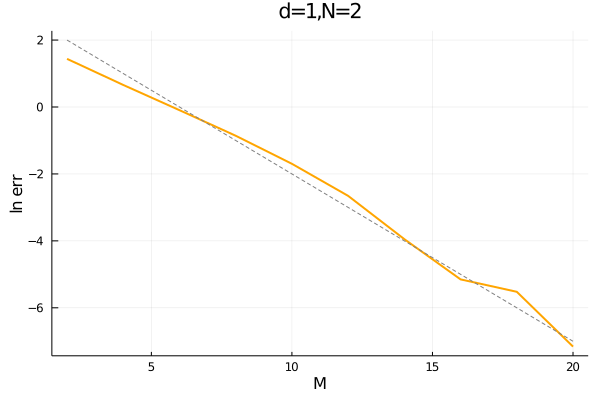

In [86]:
x=collect(2:2:20)
y=collect(2:-1:-7)
Plots.plot(x,ln_err,linewidth=2,label="",color="orange",xlabel="M",ylabel="ln err",title="d=1,N=2")
plot!(x,y,linewidth=1,ls=:dash,color="gray",label="")